## keras-OCR 

keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다.    
그 후  **text recognition model**을 활용해 문자를 인식해 보겠습니다.   

**Text recognition** 모델을 직접 만들어보도록 하겠습니다. Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해서 만들어보도록 합시다.

### module import

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


from PIL import Image, ImageDraw

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


from IPython.display import display


from keras_ocr.detection import Detector

In [18]:
BATCH_SIZE = 128
HOME_PATH = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = os.path.join(HOME_PATH, 'MJ/MJ_train')
VALID_DATA_PATH = os.path.join(HOME_PATH, 'MJ/MJ_valid')
TEST_DATA_PATH = os.path.join(HOME_PATH, 'MJ/MJ_test')

print(TRAIN_DATA_PATH)

/home/ssac27/aiffel/ocr/MJ/MJ_train


##  0. Text Recognition Model  
우선 recognition model을 만들어 보겠습니다.   
Recognition 모델은 CRNN 구조를 활용해서 만들고 데이터셋으로는 **LMDB**를 사용합니다.

###  0-1.  MJ Synth 데이터셋 클래스

lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현해 봅시다.  
- dataset_path는 읽어들일 데이터셋의 경로입니다. 
- label_converter는 문자를 미리정의된 index로 변환해주는 converter입니다. 
- 그리고 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

우선 LMDB 데이터셋이 어떻게 생겼는지 확인합니다.  

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


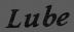

In [22]:
env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 2):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO() #  이진 데이터에 대한 fake 파일 개체
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

데이터셋을 확인해 보니 label 부분이 평문으로 되어 있어 적절하게 **Encode** 해주어야 할 것 같습니다.  

In [19]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:  # dataset_payth에서 lmdb 포멧의 파일 읽어오기
            num_samples = int(txn.get('num-samples'.encode())) 
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index) # batch 크기만큼 img, label를 가지고 옵니다.
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

**_get_img_label()** : 이미지 데이터를 img, label의 쌍으로 가져오는 메소드   
**_get_img_label()** : index에 해당하는 image와 label을 가져오는 메소드   
**\_\_getitem__()** : idx번째 배치를 가져오는 메소드   

**model.fit()**에서 호출되는 **__getitem__()** 메소드에서 배치 단위만큼 **_get_img_label()** 를 통해 가져온 데이터셋을 리턴하게 될 것입니다.    
**_get_img_label()** 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있습니다.

---

### 0-2. Label Encode
LMDB 데이터셋을 보면 Label이 평문 Text로 이루어져 있습니다.   
이것을 모델이 학습하기에는 적절한 형태가 아니므로, 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다. 

이를 해줄 수 있는 **LabelConverter** 클래스를 작성해봅시다.

- **`__init__()`** 에서는 입력으로 받은 text를 **self.dict**에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다.  
만약 **character='ABCDE**'라면 **'A'**의 label은 1, **'B'**의 label은 2가 됩니다.


- 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 **`'-'`**를 활용하며, label은 0으로 지정합니다.


- **`decode()`**는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.

In [23]:
class LabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []

        for idx, char in enumerate(text) :
            if idx >0 and char == text[idx-1] :  # 이전 문자열과 동일한 경우 [중복 문자] 공백 문자 label 포함
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])

        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해봅시다.

In [27]:
# OCR를 할때 Target이 되는 문자들
# Target LabelEncoder 
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [28]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 `'L'`이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있습니다.      
공백을 '-'로 바꾸어 동일 문자의 중복임을 알려줍니다.   
> 동일한 글자에 공백이 포함되는 이유는 아래에 설명하겠습니다.    

### 0-3. Build CRNN model  
위에서 입력, 출력의 준비과 완료되었으니 모델을 만들겠습니다.   
Keras에서 제공하는 **K.ctc_batch_cost()**를 활용해서 loss를 계산하도록 **ctc_lambda_func**를 아래와 같이 만들어두었습니다.


> **K.ctc_batch_cost** 함수 :   
**K.ctc_batch_cost(y_true, y_pred, input_length, label_length)**

In [29]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

여기서 **CTC loss**에 대해 짚고 넘어가겠습니다.    
- *중복 문자가 있을때 공백을 처리하는 이유*

![ctc_batch_cost.png](./images/ctc_batch_cost.png)

모델의 loss를 **CTC Loss**로 활용해야 하는 이유는 모델이 위 그림과 같은 상황을 다루기 위해서 임을 알아야 합니다.   

입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 라벨은 **HELLO**이지만 모델이 출력한 결과는 **HHHEEELLLOOO** 처럼 나올 수 있습니다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용됩니다.   

> 모델이 **HHHEEELLLOOO**을 출력했다고 가정하겠습니다. 이때 추론 결과는 **HELO**일지 **HELLO**일지 구분 지을 수 있을까요?  이런 경우 중복된 문자들을 다 제거하니 **HELO**로 결과를 낼것입니다.<br><br>
>그러므로 추론 결과가 **HELLO**이 되게 하려면 이미지의 라벨은 **`HEL-LO`**로 보정해 주어야 합니다. 그래서 모델이 **HHHEEEL-LLOOO**로 출력을 한다면 추론 결과는 **HELLO**가 되는 것입니다.
이런 이유로 **0-2. Label Encode** 부분에서 **`LabelConverter.encode()`** 메소드에 공백문자 처리로직을 포함했던 것입니다.  <br><br>
> - **`'-'`**를 기준으로 단어 단위로 자르고 중복을 제거하는 과정은 다음과 같습니다.  
 **`HHHEEEL-LLOOO -> HE-LLO -> HELLO`**가 된다.


**K.ctc_batch_cost()**를 활용하여, **image_input**을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 **build_crnn_model()**을 구현해 봅시다.

In [30]:
from tensorflow.keras.layers import *
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS, is_gru=False):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # input 
    conv = Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv = Conv2D(128 ,(3, 3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = MaxPooling2D(pool_size=(2,2))(conv)
    
    conv = Conv2D(256 ,(3, 3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = Conv2D(256 ,(3, 3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = MaxPooling2D(pool_size=(1,2))(conv)
    
    conv = Conv2D(512 ,(3, 3), strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(512, (3, 3), strides= (1,1), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(1,2))(conv)
    
    feature = Conv2D(512, (2, 2), strides= (1,1), activation='relu', kernel_initializer='he_normal')(conv)
    sequence = Reshape(target_shape=(24, 512))(feature)
    
    
    sequence = layers.Dense(64, activation='relu')(sequence)
    
    if is_gru :
        sequence = Bidirectional(GRU(256, return_sequences=True))(sequence)
        sequence = Bidirectional(GRU(256, return_sequences=True))(sequence)
    else :
        sequence = Bidirectional(LSTM(256, return_sequences=True))(sequence)
        sequence = Bidirectional(LSTM(256, return_sequences=True))(sequence)
    
    y_pred = Dense(num_chars, activation='softmax', name='output')(sequence)
    
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

---

### 0-4. Train & Inference   
앞에서 정의한 **MJDatasetSequence**로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다. 적절한 Epoch를 설정하여 모델을 학습시켜봅시다! 1Epoch에 10초 정도 소요될 것입니다.

In [34]:
checkpoint_path = os.path.join(HOME_PATH , 'model' , 'model_checkpoint.hdf5')
checkpoint_path

'/home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5'

In [35]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = os.path.join(HOME_PATH , 'model' , 'model_checkpoint.hdf5')

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 29.1811
Epoch 00001: val_loss improved from inf to 26.97011, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 10s 156ms/step - loss: 29.1811 - val_loss: 26.9701
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 26.5032
Epoch 00002: val_loss improved from 26.97011 to 26.40261, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 9s 143ms/step - loss: 26.5032 - val_loss: 26.4026
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 25.9795
Epoch 00003: val_loss improved from 26.40261 to 26.06578, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 133ms/step - loss: 25.9795 - val_loss: 26.0658
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 25.7275
Epoch 00004: val_loss did not improve from 26

Epoch 31/100
63/63 [==============================] - ETA: 0s - loss: 5.2769
Epoch 00031: val_loss improved from 5.72342 to 5.64446, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 5.2769 - val_loss: 5.6445
Epoch 32/100
63/63 [==============================] - ETA: 0s - loss: 5.2410
Epoch 00032: val_loss did not improve from 5.64446
63/63 [==============================] - 8s 131ms/step - loss: 5.2410 - val_loss: 5.6593
Epoch 33/100
63/63 [==============================] - ETA: 0s - loss: 4.9521
Epoch 00033: val_loss improved from 5.64446 to 5.52952, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 4.9521 - val_loss: 5.5295
Epoch 34/100
63/63 [==============================] - ETA: 0s - loss: 5.0156
Epoch 00034: val_loss improved from 5.52952 to 5.14190, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63

Epoch 63/100
63/63 [==============================] - ETA: 0s - loss: 3.5207
Epoch 00063: val_loss improved from 3.63171 to 3.50345, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 128ms/step - loss: 3.5207 - val_loss: 3.5035
Epoch 64/100
63/63 [==============================] - ETA: 0s - loss: 3.5190
Epoch 00064: val_loss improved from 3.50345 to 3.50135, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 3.5190 - val_loss: 3.5013
Epoch 65/100
63/63 [==============================] - ETA: 0s - loss: 3.4520
Epoch 00065: val_loss did not improve from 3.50135
63/63 [==============================] - 8s 127ms/step - loss: 3.4520 - val_loss: 3.5636
Epoch 66/100
63/63 [==============================] - ETA: 0s - loss: 3.2289
Epoch 00066: val_loss improved from 3.50135 to 3.46813, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63

Epoch 97/100
63/63 [==============================] - ETA: 0s - loss: 2.7559
Epoch 00097: val_loss did not improve from 2.89121
63/63 [==============================] - 8s 126ms/step - loss: 2.7559 - val_loss: 3.0160
Epoch 98/100
63/63 [==============================] - ETA: 0s - loss: 2.7394
Epoch 00098: val_loss did not improve from 2.89121
63/63 [==============================] - 8s 126ms/step - loss: 2.7394 - val_loss: 2.9085
Epoch 99/100
63/63 [==============================] - ETA: 0s - loss: 2.7776
Epoch 00099: val_loss improved from 2.89121 to 2.82671, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 2.7776 - val_loss: 2.8267
Epoch 100/100
63/63 [==============================] - ETA: 0s - loss: 2.7630
Epoch 00100: val_loss improved from 2.82671 to 2.81579, saving model to /home/ssac27/aiffel/ocr/model/model_checkpoint.hdf5
63/63 [==============================] - 8s 128ms/step - loss: 2.7630 - va

이제 학습한 모델을 테스트셋에서 inference해보고 이를 눈으로 직접 확인해보세요!

Result: 	 NATHANS99999999999999999


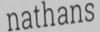

Result: 	 HALLO999999999999999999


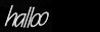

Result: 	 HURLS9999999999999999999


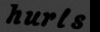

Result: 	 DOWNSIZE9999999999999999


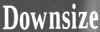

Result: 	 ROBOTIC99999999999999999


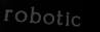

Result: 	 STOPPY99999999999999999


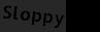

Result: 	 HERMITE99999999999999999


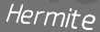

Result: 	 DEARS9999999999999999999


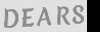

Result: 	 POLYSYLLABIC99999999999


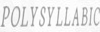

Result: 	 DETE99999999999999999999


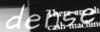

In [167]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
            print(text)
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    alpha = 3  
    for i in range(alpha,index+alpha):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

Recognition model이 제대로 작동하는것을 확인할 수 있습니다.  

이제 dataset 이외의 Sample 이미지를 받아서 다른 이미지에서도 제대로 동작을 하는지 확인해 봅시다.  

## 1. Image Detector

keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들겠습니다.  

- 이미지 내의 문자 위치를 찾을 smaple 이미지를 다운받은 후 해당 이미지로 text recognition을 진행하겠습니다.   

In [39]:
#HOME_PATH = os.getenv('HOME') + '/aiffel/ocr'
SAMPLE_IMG_PATH = os.path.join(HOME_PATH,'sample.jpg')
detector = Detector()

Looking for /home/ssac27/.keras-ocr/craft_mlt_25k.h5


In [40]:
# 이미지 크기 확인
# CV로 읽었을때 H,W,C의 순서로 파일을 읽어온다.
cv_img = cv2.imread(SAMPLE_IMG_PATH)
cv_img.shape

(900, 1200, 3)

(1200, 900)


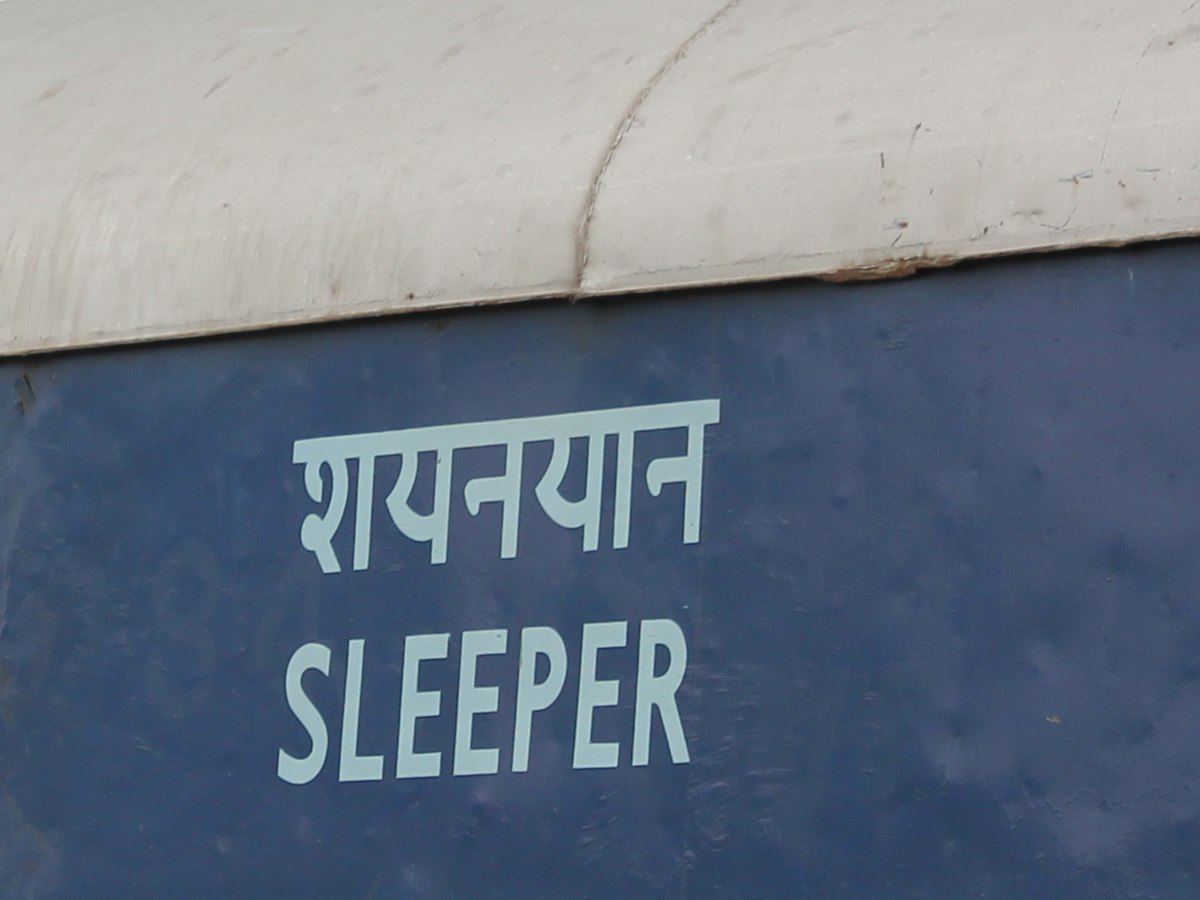

In [54]:
# 원본 Image
img_pil = Image.open(SAMPLE_IMG_PATH)
print(img_pil.size)
display(img_pil )

이미지를 읽어오는 방법에는 다음과 같습니다.   
여러 방법이 있지만, tensor로 읽어오거나 cv로 읽어올 수 있습니다.   

가지고 오는 경우 type에 차이가 있습니다.

1. tensor의 경우 : tensorflow.python.framework.ops.EagerTensor  [tensor로 읽어옵니다.]


2. numpy.ndarray : numpy.ndarray로 읽어 옵니다.  

In [144]:
# tenso로 이미지 데이터 읽기

def parse_image(img_path) :
    if not os.path.exists(img_path) :
        print("경로 내의 파일이 없습니다.  \n")
    img = tf.io.read_file(SAMPLE_IMG_PATH)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.convert_image_dtype(img, tf.uint8)
    img = tf.image.resize(img,[600,600])  # 900,1200  = 3:4 
    img = img[tf.newaxis, :, :, :]
    return img

In [79]:
# cv로 이미지 데이터 읽기

def cv_parse_image(img_path) :
    if not os.path.exists(img_path) :
        print("경로 내의 파일이 없습니다.  \n")
    img = cv2.imread(img_path)
    #print(img.shape)
    img = cv2.resize(img, dsize=(600,600))  # y,x 순이다.
    #print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[np.newaxis, :, :, :]
    return img

In [146]:
img = parse_image(SAMPLE_IMG_PATH)
img.shape

TensorShape([1, 600, 600, 3])

In [147]:
type(img)

tensorflow.python.framework.ops.EagerTensor

In [148]:
cv_img = cv_parse_image(SAMPLE_IMG_PATH)
cv_img.shape

(1, 600, 600, 3)

In [149]:
type(cv_img)

numpy.ndarray

(600, 600, 3)


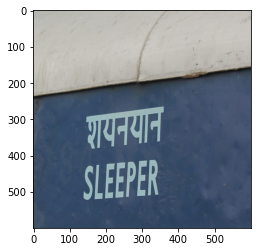

In [150]:
# tensor로 읽어온 img
print(img[0].shape)
# 높이, 너비, 채널
plt.imshow(img[0])

(600, 600, 3)


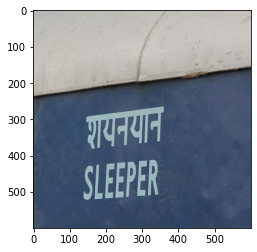

In [151]:
# cv로 읽어온 img
print(cv_img[0].shape)
# 높이, 너비, 채널
plt.imshow(cv_img[0])

In [152]:
print("cv_img.shape : ", cv_img.shape)

print("img.shape : ", img.shape)

cv_img.shape :  (1, 600, 600, 3)
img.shape :  (1, 600, 600, 3)


type의 차이가 있을뿐 읽어 온 결과는 동일합니다.   

In [349]:
# img size를 600, 600으로 해야 boungind box가 잘 그려진다.
def detect_text(img_path):
    # TODO

    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # tensor, cv로 읽어올 수 있습니다.  두 방식의 결과는 동일합니다.
    
    # tensor image 이때 data type을 uint8로 맞춰주어야 한다.
    #img = parse_image(img_path)
    #img = tf.image.convert_image_dtype(img, tf.uint8)
    
    # detector.detect() 인자로 numpy.ndarray type이 들어가야 하니 numpy()로 convert해주어야 합니다.
    # ocr_detect = detector.detect(img.numpy())
    
    # cv image
    img = cv_parse_image(img_path)
    
    ocr_detect = detector.detect(img)
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = ocr_detect[0]

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    # PIL image로 가지고 옵니다.
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize(size=(600,600))
    result_img = img_pil
    img_draw = ImageDraw.Draw(img_pil)
    
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

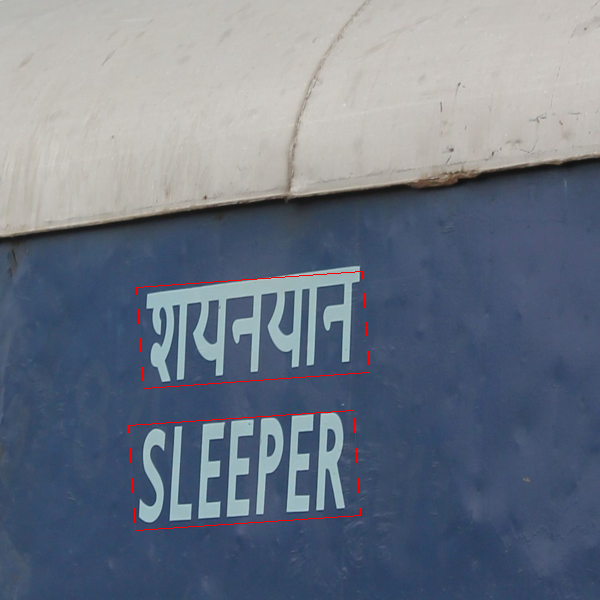

In [350]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

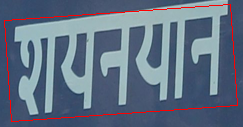

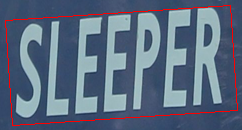

In [165]:
display(cropped_img[0])
display(cropped_img[1])

이미지 내의 단어 이미지를 얻었습니다.   이제 **Recognition model**로 인식하는 함수를 만들고 결과를 보겠습니다.

## 2. Recognition image
단어 image를 입력받으면 단어를 인식한 후 결과를 return하는 함수인 **recognize_img()**를 만들어 봅시다.   

In [175]:
print(type(cropped_img[0]))
print(cropped_img)


<class 'PIL.Image.Image'>
[<PIL.Image.Image image mode=RGB size=243x127 at 0x7F41BC030F10>, <PIL.Image.Image image mode=RGB size=242x130 at 0x7F41BC02B850>]


위에서 얻은 cropped img가 model에 들어가기 위해선 shape, type을 바꿀 필요가 있습니다.   

In [312]:
import re 

In [357]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # 잘려진 단어를 입력받은 후 해당 이미지의 단어를 인식하는 함수
    
    # pil_img.resize shape : 32, 100, 3  
    pil_img = pil_img.resize(input_img_size)  # resize를 하면서 x,y -> y,x 로 바뀌었다.  
    np_img = np.array(pil_img)   # numpy.ndarray
    np_img = np.transpose(np_img, (1,0,2))  # shape를 100,32,3으로 transpose y,x -> x,y
    np_img = np_img[np.newaxis, :, :, :]  # batch_size의 1 추가   (1, 100, 32, 3)

    output = model_pred.predict(np_img)
    
    
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    
    result = re.sub(r'\d', '', result) # 숫자 출력은 제외하겠습니다  
    print("Result: \t", result)
    display(Image.fromarray(np_img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 AN


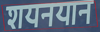

Result: 	 SLEEPER


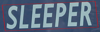

In [345]:
for _img in cropped_img:
    recognize_img(_img)

다른 이미지에서도 적용이 되는지 확인해 보겠습니다.  

In [408]:
SAMPLE_IMG_PATH2 = os.path.join(HOME_PATH,'sample2.jpeg')

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2250x3000 at 0x7F3712FECE10>


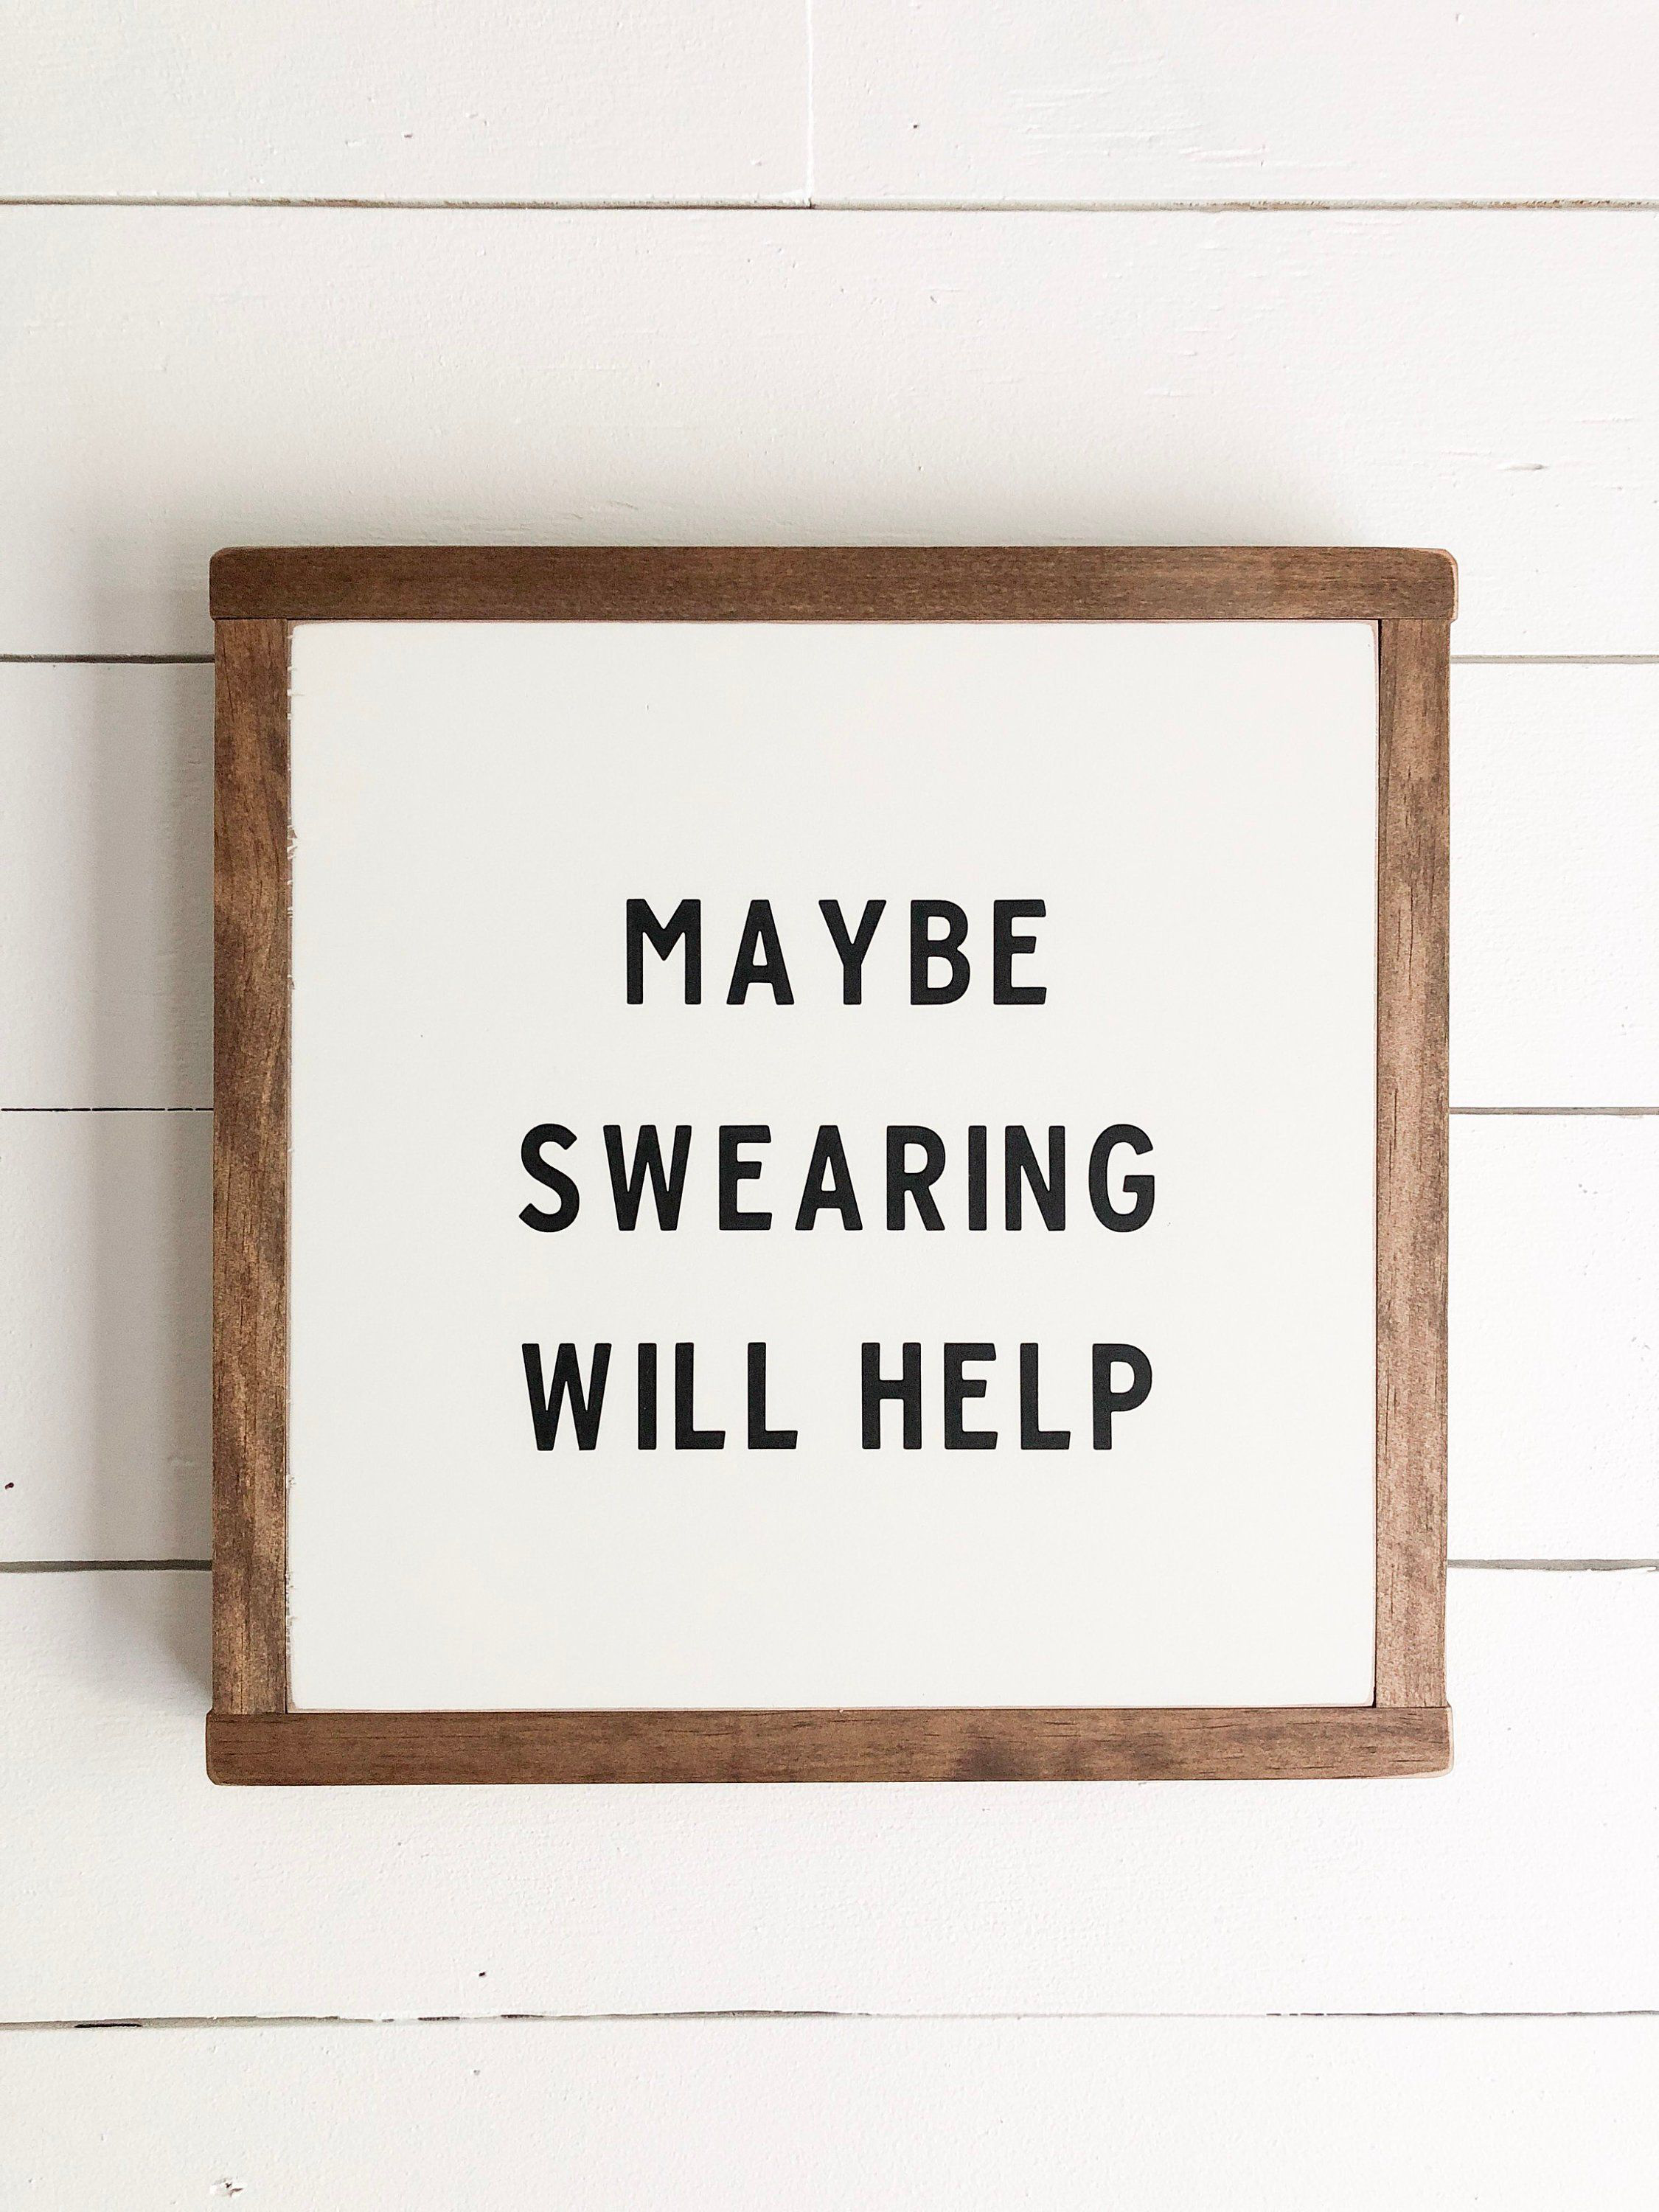

In [415]:
# SAMPLE image 2
img_smaple2 = Image.open(SAMPLE_IMG_PATH2)
print(img_smaple2)
display(img_smaple2)

#### Text Detector 확인
Sample_2 image에서 글자 detect가 잘 되었는지 확인하겠습니다.   

위의 detect_text() 함수를 사용합니다. 

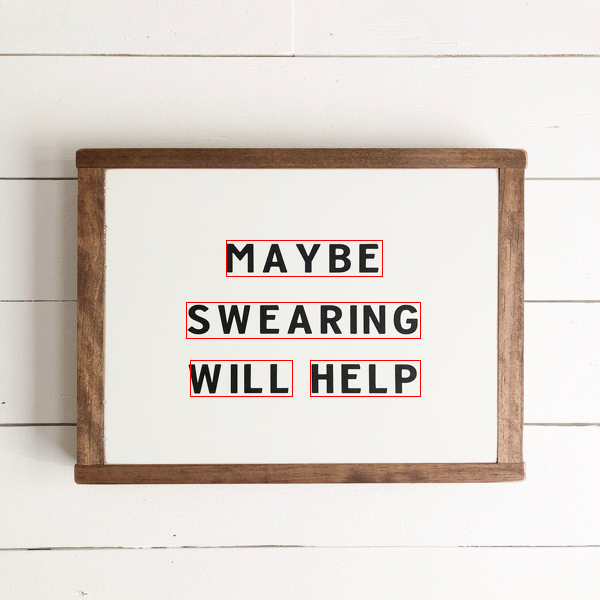

In [416]:
img_pil2, cropped_img2 = detect_text(SAMPLE_IMG_PATH2)
display(img_pil2)

이제 cropped_img를 확인해 봅시다.   
현재 Sample image도 위에와 같이 2개의 이미지만 확인을 해보겠습니다.  

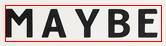

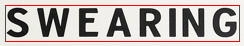

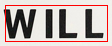

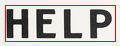

In [419]:
# cropped image 확인 
for _img in cropped_img2 :
    display(_img)

위에 cropped된 이미지를 가지고 Text recognition을 진행해봅시다.  

위에서 만든 **recognize_img()** 함수를 사용하겠습니다.  

Result: 	 MAYBE


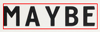

Result: 	 SWEARING


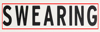

Result: 	 WILLI


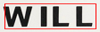

Result: 	 HELPI


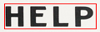

In [420]:
for _img in cropped_img2 :
    recognize_img(_img)

문자인식이 대부분 잘 이루어 졌습니다.   


---

## 회고  
-  문자 인식의 경우 text에 대해서도 알아야하고 object detection에 대해서도 알아야해서 어렵지만 결과가 한눈에 잘 보이기에 더 재밌는것 같습니다.   


- OCR이 생각보다 더 잘되어서 기분좋게 프로젝트를 진행한것 같습니다.  
그리고 프로젝트 진행하면서 중복된 문자의 경우 어떻게 처리를 해서 중복임을 나타내는지 궁굼했는데 이번에 **ctc_loss**에 대해서 알게되면서 중복된 문자를 어떻게 처리하는지 알게 되어서 나중에 비슷한 문제를 해결해야할 때 쓸 수 있을것 같습니다.   


- OCR 프로젝트를 진행하면서 '해당 기술이 어디에 쓰일 수 있을까?'하고 생각을 해보았는데 영어 논문 같은 경우 PDF로 되어 있어서 구글 번역이 잘 적용이 안되는게 생각이 났습니다.    
이 OCR의 정확도를 높이고 Latex 수식이랑 일반 평문이랑 구분할 수 있으면 영어 논문을 한글로 쉽게 번역할 수 있지 않을까? 하는 생각이 들었습니다.    <br> 이 부분은 좀 더 공부를 하고 할 수 있으면 토이프로젝트로 한번 진행해 보고 싶긴 하네요.
